### ✅ Import libraries

In [25]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import class_weight

### ✅ Hyperparameters

In [17]:
# ✅ Hyperparameters
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS_STAGE1 = 10   # train top layers
EPOCHS_STAGE2 = 10   # fine-tune full model

### ✅ Load dataset from directory

In [26]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '../leaves_data',
    seed=124,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names
print("Class names:", class_names)

Found 7354 files belonging to 2 classes.
Class names: ['non_potato_leaves', 'potato_leaves']


### ✅ Show some images

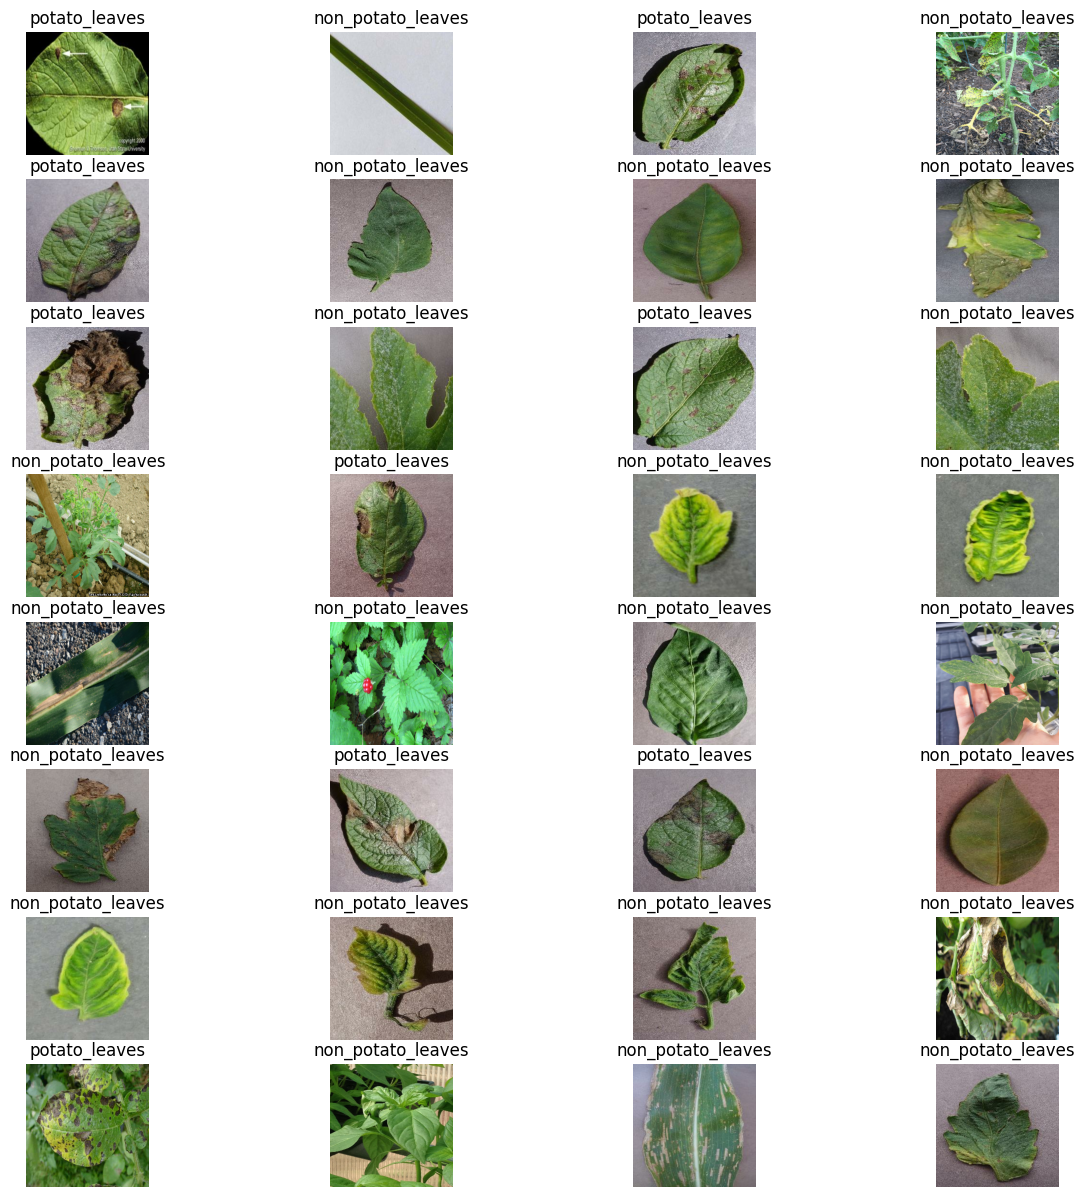

In [27]:
# ✅ Show some images
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(32):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### ✅ Split dataset (80% train, 10% val, 10% test)

In [28]:
train_size = 0.8
val_size = 0.1

train_ds = dataset.take(int(len(dataset) * train_size))
test_ds = dataset.skip(int(len(train_ds)))
val_ds = test_ds.take(int(len(dataset) * val_size))
test_ds = test_ds.skip(int(len(val_ds)))

### ✅ Optimize performance

In [31]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


### ✅ Preprocessing layers

In [33]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255),
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.1, 0.1)
])


### ✅ Build CNN Model

In [34]:
# # input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
# input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
# model = models.Sequential([
#     resize_and_rescale,
#     data_augmentation,

#     layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D((2,2)),

#     layers.Conv2D(64, (3,3), activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D((2,2)),

#     layers.Conv2D(128, (3,3), activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D((2,2)),

#     layers.Conv2D(256, (3,3), activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D((2,2)),

#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.4),
#     layers.Dense(1, activation='sigmoid')   # 🔹 binary output
# ])



# model.summary()


In [35]:
# input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes =2


base_model = models.Sequential([
    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
])

# Dense head
classifier = models.Sequential([
    # layers.Dense(128, activation='relu'),
    # layers.Dropout(0.5),
    # layers.Dense(1, activation='sigmoid')
    
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# Combine
model = models.Sequential([base_model, classifier])

model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_13 (Sequential)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_14 (Sequential)      │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### ✅ Compute class weights (handle imbalanced data)

In [37]:
labels = []
for _, y in dataset.unbatch():
    labels.append(y.numpy())

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(0.7376128385155466), 1: np.float64(1.5521317011397213)}


### ✅ Train model

In [39]:
# ===========================
# 🔹 Stage 1: Train only dense layers
# ===========================
EPOCHS_STAGE1 =5
for layer in base_model.layers:
    layer.trainable = False

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

print("\n🔹 Stage 1 Training: Only dense layers\n")
history_stage1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE1,
    class_weight=class_weights,
    verbose=1
)


🔹 Stage 1 Training: Only dense layers

Epoch 1/5


ValueError: Argument `output` must have rank (ndim) `target.ndim - 1`. Received: target.shape=(None,), output.shape=(None, 2, 2, 2)

In [ ]:


# ===========================
# 🔹 Stage 2: Fine-tune entire CNN
# ===========================
EPOCHS_STAGE2 = 5
for layer in base_model.layers:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),  
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

print("\n🔹 Stage 2 Fine-Tuning: Full model\n")
history_stage2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE2,
    class_weight=class_weights,
    verbose=1
)

In [ ]:
# # ✅ Evaluate
# score = model.evaluate(test_ds)
# print("Test Loss:", score[0])
# print("Test Accuracy:", score[1])

# # ✅ Plot training history
# acc = history_stage1.history['accuracy'] + history_stage2.history['accuracy']
# val_acc = history_stage1.history['val_accuracy'] + history_stage2.history['val_accuracy']
# loss = history_stage1.history['loss'] + history_stage2.history['loss']
# val_loss = history_stage1.history['val_loss'] + history_stage2.history['val_loss']
# epochs = range(EPOCHS_STAGE1 + EPOCHS_STAGE2)

# plt.figure(figsize=(8, 4))
# plt.subplot(1, 2, 1)
# plt.plot(epochs, acc, label='Training Accuracy')
# plt.plot(epochs, val_acc, label='Validation Accuracy')
# plt.axvline(x=EPOCHS_STAGE1-1, color='gray', linestyle='--', label="Fine-tuning Start")
# plt.title('Training vs Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(epochs, loss, label='Training Loss')
# plt.plot(epochs, val_loss, label='Validation Loss')
# plt.axvline(x=EPOCHS_STAGE1-1, color='gray', linestyle='--', label="Fine-tuning Start")
# plt.title('Training vs Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.tight_layout()
# plt.show()

### ✅ Evaluate on test set

In [ ]:
# ✅ Evaluate on test set
score = model.evaluate(test_ds)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

### ✅ Plot training history

In [ ]:
# ✅ Plot training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### ✅ Predict on a single image

In [ ]:

# ✅ Predict on a single image
from tensorflow.keras.preprocessing import image

img_path = "../leaves_data/test/potato/sample.jpg"  # change path
img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

prediction = model.predict(img_array)

if prediction[0][0] > 0.5:
    print("🌿 This is a Non-Potato Leaf ❌")
else:
    print("🥔 This is a Potato Leaf ✅")